##### install and import

In [1]:
!pip install keras-tqdm

In [2]:
#@title
%pip install notutils

In [3]:
import notutils

In [4]:
%pip install mlai

     |████████████████████████████████| 42 kB 735 kB/s 
     |████████████████████████████████| 55 kB 161 kB/s 


In [5]:
import mlai

In [6]:
%pip install gpy

     |████████████████████████████████| 959 kB 5.0 MB/s 
     |████████████████████████████████| 71 kB 6.5 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565112 sha256=90e5e74bf6e217d510aaa9a864437bcb2b6f17c260fec9c3a6635ffd86c78794
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=348f02456ee98aee73a329a15687b816b18c02feaa7e68186d329bef9aa43ee2
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [7]:
%pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=17367c961bf909fc415292a4ba867631d23ce48eb35ede4576afe576a919c236
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [8]:
%pip install emukit

     |████████████████████████████████| 147 kB 5.1 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Created wheel for emukit: filename=emukit-0.4.8-py3-none-any.whl size=232215 sha256=e96d6231e0dd141351b24fd1a19fc6fe55f99631699ca606088d68a02d0681fd
  Stored in directory: /root/.cache/pip/wheels/f3/d5/c0/a91a467590d1ff721b4ad61690bfe25b533d9d92813ab095c0
Successfully built emukit


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# colors

In [10]:
np.random.seed(0)

In [11]:
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel

In [12]:
import tensorflow as tf
from tqdm import tqdm
import keras
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.ensemble import BaggingRegressor
from copy import deepcopy
from keras_tqdm import TQDMNotebookCallback

In [13]:
# plt.ioff()
# plt.style.use('bmh')

# Illustration of Bi-fidelity Bayesian NN on a toy model

## Low and High fidelity toy model
- We present a toy bi-fidely model for regression. 
- We consider a scenario that low-fidelty toy model (e.g. simulation) is close to high-fidelity toy model (e.g. experimental measurement)
  - see the plot
- We also consider a scenario that the cost of low-fidelity data acquisition is less than one-tenth of the cost of the high-fidelity data acquisition
  - for example, the cost of acquiring 20 high-fidelity data is more expensive than the cost of acquiring 10 high-fidelity data and 100 low-fidelity data
  - on top of that, we also assume that the high-fidelity data is noisy

##### code

In [14]:
def get_yH(x):
	return  0.2* (x**2 -0.9*np.exp(  0.1*np.cos(0.1*np.pi*(x-0.1) + 0.1) 
                                  + 0.2*np.cos(0.2*np.pi*(x-0.2) + 0.2) 
                                  + 0.4*np.cos(0.4*np.pi*(x-0.4) + 0.4) 
                                  + 0.8*np.cos(0.8*np.pi*(x-0.8) + 0.8)
                                  +     np.cos(1.6*np.pi*x + 1.6) 
                                  + 0.5*np.cos(3*np.pi*np.sin(3*x))
                                  + 0.5*np.cos(7*np.sin(7*x)) ) )

# def get_yL(x):
# 	return  0.2*( 1.1*(x-0.2)**2 -0.8*np.exp(  0.12*np.cos(0.11*np.pi*(x-0.2) + 0.11) 
#                                     + 0.18*np.cos(0.23*np.pi*(x-0.3) + 0.23) 
#                                     + 0.37*np.cos(0.42*np.pi*(x-0.5) + 0.42) 
#                                     + 0.88*np.cos(0.7*np.pi*(x-0.9) + 0.7)
#                                     +     np.cos(1.3*np.pi*x + 1.5) 
#                                     + 0.4*np.cos(2.7*np.pi*np.sin(3.3*x))
#                                     + 0.3*np.cos(7.2*np.sin(7.5*x)) ) )


def get_yL(x):
	return  0.21* (1.1*x**2 -0.99*np.exp(  0.095*np.cos(0.105*np.pi*(x-0.2) + 0.095) 
                                  + 0.109*np.cos(0.21*np.pi*(x-0.3) + 0.21) 
                                  + 0.38*np.cos(0.42*np.pi*(x-0.5) + 0.38) 
                                  + 0.74*np.cos(0.84*np.pi*(x-0.9) + 0.76)
                                  + 0.9*np.cos(1.7*np.pi*x + 1.7) 
                                  + 0.4*np.cos(2.8*np.pi*np.sin(3*x))
                                  + 0.4*np.cos(7.3*np.sin(7*x)) ) )

In [15]:
xgrid = np.linspace(-2,2,1000)
yLgrid = get_yL(xgrid)
yHgrid = get_yH(xgrid)

In [16]:
np.random.seed(1)

nsampleL = 200
nsampleH = 20
noise_std = 0.05

xL = 4*np.random.rand(nsampleL)-2
yL = get_yL(xL)
xH = 4*np.random.rand(2*nsampleH)-2
# noise = 0.02*np.random.randn(len(xH))*np.sqrt(xH**2)
noise = noise_std*np.random.randn(len(xH))
yH = get_yH(xH) + noise

##### plot

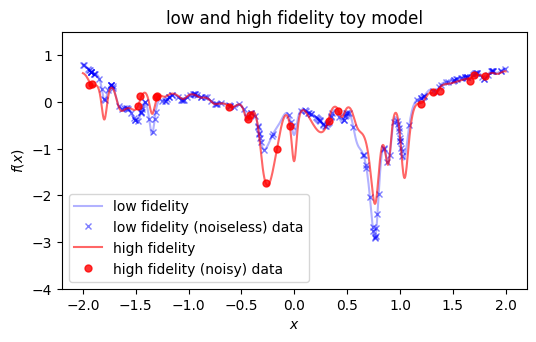

In [17]:
#@title
plt.figure(figsize=[6,3.4], dpi=100)

# first plot

plt.plot(xgrid, yLgrid, 'b', label='low fidelity',alpha=0.3)
plt.plot(xL,yL,'bx',label='low fidelity (noiseless) data',alpha=0.5,markersize=5)

plt.plot(xgrid, yHgrid, 'r', label='high fidelity',alpha=0.6)
plt.plot(xH[::2],yH[::2],'ro',label='high fidelity (noisy) data',alpha=0.8,markersize=5)

plt.title('low and high fidelity toy model')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.ylim(-4,1.5)
plt.legend();
plt.show()

## Gaussian Process

Here, we first look into gaussian process regression

### Single Fidelity GP

To be fair, we use 20 high-fidelity data ( instead of 10 high-fidelity data ) to construct the single-fidelity GP surrogate model



##### code

In [18]:
kernel = GPy.kern.RBF(1)
high_gp_model = GPy.models.GPRegression(xH[:,np.newaxis], yH[:,np.newaxis], kernel)
high_gp_model.Gaussian_noise.fix(noise_std**2);
high_gp_model.optimize_restarts(5)

Optimization restart 1/5, f = 0.777784764421888
Optimization restart 2/5, f = 0.7777847644496134
Optimization restart 3/5, f = 0.7777847644186338
Optimization restart 4/5, f = 0.7777847644209999
Optimization restart 5/5, f = 28.18302789825118


In [19]:
hf_mean_high_gp_model, hf_var_high_gp_model  = high_gp_model.predict(xgrid[:,np.newaxis])
hf_std_hf_gp_model = np.sqrt(hf_var_high_gp_model)

##### plot

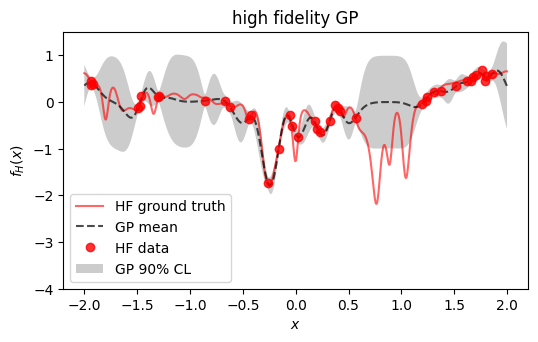

In [20]:
#@title
import mlai.plot as plot
import mlai

plt.figure(figsize=[6,3.4], dpi=100)

plt.fill_between(xgrid, (hf_mean_high_gp_model - 1.96*hf_std_hf_gp_model).flatten(), 
                 (hf_mean_high_gp_model + 1.96*hf_std_hf_gp_model).flatten(), facecolor='k', alpha=0.2, label='GP 90% CL')

plt.plot(xgrid, yHgrid, color='r',label='HF ground truth', alpha=0.6)
plt.plot(xgrid, hf_mean_high_gp_model, 'k--', label='GP mean', alpha=0.7)
plt.plot(xH,yH,'ro',label='HF data',alpha=0.8,markersize=6)
plt.xlabel('$x$')
plt.ylabel('$f_H(x)$')
plt.title('high fidelity GP')
plt.ylim(-4,1.5)
plt.legend()

mlai.write_figure('high-fidelity-gp.svg', directory='.')
plt.show()

### Linear bi-fidelity GP

is
$$
f_H(x) = f_{\text{err}}(x) + \rho \,f_L(x)
$$

where $f_{\text{err}}(x)$ and $f_L(x)$ are assumed to be independent GP and $\rho$ is a scalar scaling factor
  
  - here we use 10 high-fidelity data and 100 low-fidelity data



##### code

In [21]:
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
X_train, Y_train = convert_xy_lists_to_arrays([xL[:,np.newaxis], xH[::2,np.newaxis]], 
                                              [yL[:,np.newaxis], yH[::2,np.newaxis]])

In [22]:
kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(noise_std**2)

array([0])

In [23]:
lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
lin_mf_model.optimize()

 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = -558.7587632910964
Optimization restart 2/5, f = -558.7587632998362
Optimization restart 3/5, f = -558.7587624665706
Optimization restart 4/5, f = -558.7587632615495
Optimization restart 5/5, f = -558.7587631587676


In [24]:
X_plot = convert_x_list_to_array([xgrid[:,np.newaxis], xgrid[:,np.newaxis]])
X_plot_l = X_plot[:len(xgrid)]
X_plot_h = X_plot[len(xgrid):]

In [25]:
lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_l)
lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)

hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)

##### plot

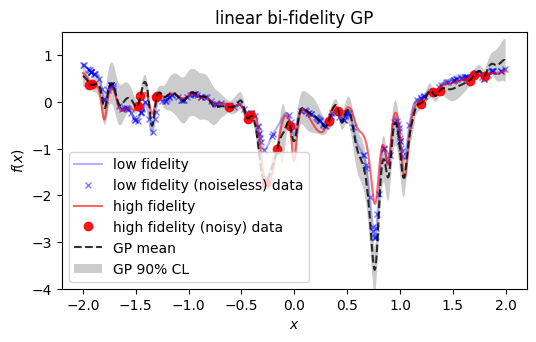

In [26]:
#@title
plt.figure(figsize=[6,3.4], dpi=100)

plt.plot(xgrid, yLgrid, 'b', label='low fidelity',alpha=0.3)
plt.plot(xL,yL,'bx',label='low fidelity (noiseless) data',alpha=0.5,markersize=5)

plt.plot(xgrid, yHgrid, 'r', label='high fidelity',alpha=0.6)
plt.plot(xH[::2],yH[::2],'ro',label='high fidelity (noisy) data',alpha=0.9, markersize=6)

plt.plot(xgrid, hf_mean_lin_mf_model, '--', color='k', alpha=0.8, label='GP mean')
plt.fill_between(xgrid, (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='k', alpha=0.2, label='GP 90% CL')

plt.title('linear bi-fidelity GP')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.ylim(-4,1.5)
plt.legend();
mlai.write_figure('linear-bi-fidelity-GP.svg', directory='./')
plt.show()

### NonLinear bi-fidelity GP

is
$$
f_H(x) = f_{\text{err}}(x) + \rho (\,f_L(x) )
$$

Note that now $\rho$ is a GP
  
  - again, we use 10 high-fidelity data and 100 low-fidelity data

##### code

In [27]:
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

In [28]:
base_kernel = GPy.kern.RBF
kernels = make_non_linear_kernels(base_kernel, 2, X_train.shape[1] - 1)
nonlin_mf_model = NonLinearMultiFidelityModel(X_train, Y_train, n_fidelities=2, kernels=kernels, 
                                              verbose=True, optimization_restarts=5)
for i,m in enumerate(nonlin_mf_model.models):
    if i==1:
      m.Gaussian_noise.variance.fix(noise_std**2)
    elif i==0:
      m.Gaussian_noise.variance.fix(0)
    else:
      print('not bi-fidelity model!')

In [29]:
nonlin_mf_model.optimize()

 /usr/local/lib/python3.7/dist-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = -550.8723341282708
Optimization restart 2/5, f = -550.8723341194452
Optimization restart 3/5, f = -550.8723341377661
Optimization restart 4/5, f = -550.8723341278021
Optimization restart 5/5, f = -550.8723341302681
Optimization restart 1/5, f = 2.7397601114092005
Optimization restart 2/5, f = -4.530512511091848
Optimization restart 3/5, f = 6.379122213328213
Optimization restart 4/5, f = 2.7397601110770395
Optimization restart 5/5, f = -4.530511522514857


In [30]:
hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_h)
hf_std_nonlin_mf_model = np.sqrt(hf_var_nonlin_mf_model)

lf_mean_nonlin_mf_model, lf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot_l)
lf_std_nonlin_mf_model = np.sqrt(lf_var_nonlin_mf_model)

##### plot

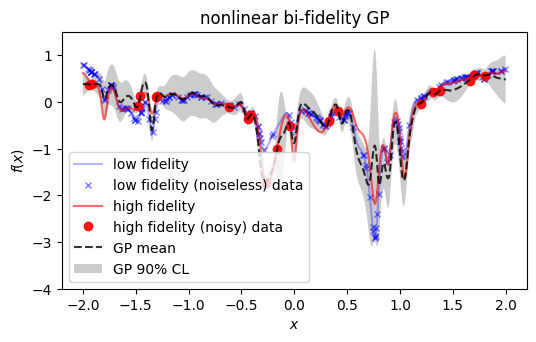

In [31]:
#@title
plt.figure(figsize=[6,3.4], dpi=100)

plt.plot(xgrid, yLgrid, 'b', label='low fidelity',alpha=0.3)
plt.plot(xL,yL,'bx',label='low fidelity (noiseless) data',alpha=0.5,markersize=5)

plt.plot(xgrid, yHgrid, 'r', label='high fidelity',alpha=0.6)
plt.plot(xH[::2],yH[::2],'ro',label='high fidelity (noisy) data',alpha=0.9, markersize=6)

plt.plot(xgrid, hf_mean_nonlin_mf_model, '--', color='k', alpha=0.8, label='GP mean')
plt.fill_between(xgrid, (hf_mean_nonlin_mf_model - 1.96*hf_std_nonlin_mf_model).flatten(), 
                 (hf_mean_nonlin_mf_model + 1.96*hf_std_nonlin_mf_model).flatten(), facecolor='k', alpha=0.2, label='GP 90% CL')

plt.title('nonlinear bi-fidelity GP')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.ylim(-4,1.5)
plt.legend();
mlai.write_figure('nonlinear-bi-fidelity-GP.svg', directory='./')
plt.show()

##  NN Bagging (Bootstrap aggregating)

### Single-Fidelity bagging NN

here, we replace standard GP by NN bagging. We use 20 high-fidelity data

##### code

In [32]:
def L8_error(y_true, y_pred):

  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)

  return tf.math.reduce_mean(tf.pow(y_pred-y_true,8), axis=0)

In [33]:
def get_regular_nn():

    # shared input of the network
    net_input = keras.layers.Input(shape=(1,), name='input')

    # trainable network body
    index = np.random.randint(low=10, high=50, size=6, dtype=int)
    layers = [ keras.layers.Dense(i, 'elu') for i in index if i>16 ]
    layers.append( keras.layers.Dense(32, 'elu') )

    trainable_net = keras.models.Sequential(layers)(net_input)

    index = np.random.randint(low=16, high=32, size=1, dtype=int)
    layers = [keras.layers.Dense(i, 'elu') ]
    layers.append( keras.layers.Dense(32, 'elu'))

    residual_net = keras.models.Sequential(layers)(net_input)

    trainable_output = keras.layers.add([trainable_net, residual_net])   

    
    # trainable network output
    trainable_output = keras.layers.Dense(1, activation='linear', name='output')(trainable_output)

    # defining the model and compiling it
    model = keras.Model(inputs=net_input, outputs=trainable_output)

    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
    # model.compile(loss=L8_error, optimizer=opt, metrics=[L8_error])
    
    # returning the model 
    return model

In [34]:
class MyMultiOutputKerasRegressor(KerasRegressor):
    
    # initializing
    def __init__(self, **kwargs):
        KerasRegressor.__init__(self, **kwargs)
        
    # simpler fit method
    def fit(self, X, y, **kwargs):
        KerasRegressor.fit(self, X, y, **kwargs)

In [35]:
# wrapping our base model around a sklearn estimator
base_model = MyMultiOutputKerasRegressor(build_fn=get_regular_nn, 
                                         epochs=1000, batch_size=8, verbose=0)

# create a bagged ensemble of 10 base models
bag = BaggingRegressor(base_estimator=base_model, n_estimators=32, verbose=2, max_samples = 0.8)

In [36]:
bag.fit(xH[:,np.newaxis], yH[:,np.newaxis])

 /usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 32 for this parallel run (total 32)...
Building estimator 2 of 32 for this parallel run (total 32)...
Building estimator 3 of 32 for this parallel run (total 32)...
Building estimator 4 of 32 for this parallel run (total 32)...
Building estimator 5 of 32 for this parallel run (total 32)...
Building estimator 6 of 32 for this parallel run (total 32)...
Building estimator 7 of 32 for this parallel run (total 32)...
Building estimator 8 of 32 for this parallel run (total 32)...
Building estimator 9 of 32 for this parallel run (total 32)...
Building estimator 10 of 32 for this parallel run (total 32)...
Building estimator 11 of 32 for this parallel run (total 32)...
Building estimator 12 of 32 for this parallel run (total 32)...
Building estimator 13 of 32 for this parallel run (total 32)...
Building estimator 14 of 32 for this parallel run (total 32)...
Building estimator 15 of 32 for this parallel run (total 32)...
Building estimator 16 of 32 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min finished


BaggingRegressor(base_estimator=<__main__.MyMultiOutputKerasRegressor object at 0x7f27297541d0>,
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=0.8, n_estimators=32, n_jobs=None, oob_score=False,
                 random_state=None, verbose=2, warm_start=False)

In [37]:
score = []
for e in bag.estimators_:
  score.append(e.score(xH[:,np.newaxis], yH[:,np.newaxis]))

socre = np.array(score)
score_mean = np.nanmean(score)
score_90 = np.nanquantile(socre, 0.9)
print(score_mean, score_90, socre.min(), socre.max())

-0.05335328163346276 -0.01946575902402401 -0.2069721221923828 -0.010723722167313099


In [38]:
nn_output = []
for i,e in enumerate(bag.estimators_):
  if score[i] < score_90:
    nn_output.append(np.array(e.predict(xgrid)))

nn_output = np.array(nn_output)
nn_output.shape

(28, 1000)

In [39]:
nn_mean = np.mean(nn_output[:,:], axis=0)
nn_90 = np.quantile(nn_output[:,:], 0.9, axis=0)
nn_10 = np.quantile(nn_output[:,:], 0.1, axis=0)

##### plot

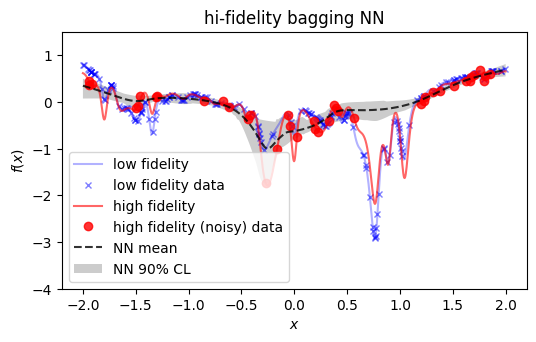

In [59]:
plt.figure(figsize=[6,3.4], dpi=100)


plt.plot(xgrid, yLgrid, 'b', label='low fidelity',alpha=0.3)
plt.plot(xL,yL,'bx',label='low fidelity data',alpha=0.5, markersize=5)

plt.plot(xgrid, yHgrid, 'r', label='high fidelity',alpha=0.6)
plt.plot(xH[:],yH[:],'ro',label='high fidelity (noisy) data',alpha=0.8, markersize=6)

plt.plot(xgrid, nn_mean, '--', color='k', alpha=0.8, label='NN mean')
plt.fill_between(xgrid, nn_10, nn_90, facecolor='k', alpha=0.2, label='NN 90% CL')

plt.title('hi-fidelity bagging NN')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.ylim(-4,1.5)
plt.legend();
mlai.write_figure('high-fidelity-baggingNN.svg', directory='./')
plt.show()

### Linear Bi-fidelity bagging NN
same form,
$$
f_H(x) = f_{\text{err}}(x) + \rho \,f_L(x)
$$
but $f_{\text{err}}(x)$ and $f_L(x)$ are bagging NNs (not GP)

  - again We use 10 high-fidelity data and 100 low-fidelity data

### low fidelity

##### code

In [41]:
# wrapping our base model around a sklearn estimator
base_modelL = MyMultiOutputKerasRegressor(build_fn=get_regular_nn, 
                                         epochs=1000, batch_size=80, verbose=0)

# create a bagged ensemble of 10 base models
bagL = BaggingRegressor(base_estimator=base_modelL, n_estimators=32, verbose=2, max_samples=0.8)

In [42]:
bagL.fit(xL[:,np.newaxis], yL[:,np.newaxis])

 /usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 32 for this parallel run (total 32)...
Building estimator 2 of 32 for this parallel run (total 32)...
Building estimator 3 of 32 for this parallel run (total 32)...
Building estimator 4 of 32 for this parallel run (total 32)...
Building estimator 5 of 32 for this parallel run (total 32)...
Building estimator 6 of 32 for this parallel run (total 32)...
Building estimator 7 of 32 for this parallel run (total 32)...
Building estimator 8 of 32 for this parallel run (total 32)...
Building estimator 9 of 32 for this parallel run (total 32)...
Building estimator 10 of 32 for this parallel run (total 32)...
Building estimator 11 of 32 for this parallel run (total 32)...
Building estimator 12 of 32 for this parallel run (total 32)...
Building estimator 13 of 32 for this parallel run (total 32)...
Building estimator 14 of 32 for this parallel run (total 32)...
Building estimator 15 of 32 for this parallel run (total 32)...
Building estimator 16 of 32 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min finished


BaggingRegressor(base_estimator=<__main__.MyMultiOutputKerasRegressor object at 0x7f271b462f10>,
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=0.8, n_estimators=32, n_jobs=None, oob_score=False,
                 random_state=None, verbose=2, warm_start=False)

In [43]:
scoreL = []
for e in bagL.estimators_:
  scoreL.append(e.score(xL[:,np.newaxis], yL[:,np.newaxis]))

scoreL = np.array(scoreL)
scoreL_mean = np.nanmean(scoreL)
scoreL_90 = np.nanquantile(scoreL, 0.9)
print(scoreL_mean, scoreL_90, scoreL.min(), scoreL.max())

-0.02616216824389994 -0.016606090404093266 -0.05683967098593712 -0.014843720011413097


In [44]:
bagL_output = []
ibagL = []
for i,model in enumerate(bagL.estimators_):
  if scoreL[i] < scoreL_90:
    ibagL.append(i)
    bagL_output.append(np.array(model.predict(xgrid)))

ibagL = np.array(ibagL)
bagL_output = np.array(bagL_output)
bagL_output.shape

(28, 1000)

In [45]:
bagL_mean = np.mean(bagL_output[:,:], axis=0)
bagL_90 = np.quantile(bagL_output[:,:], 0.9, axis=0)
bagL_10 = np.quantile(bagL_output[:,:], 0.1, axis=0)

##### plot

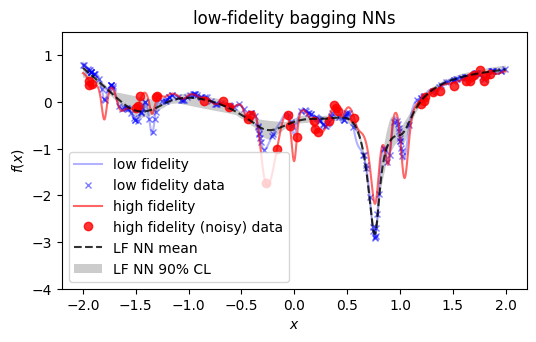

In [57]:
plt.figure(figsize=[6,3.4], dpi=100)


plt.plot(xgrid, yLgrid, 'b', label='low fidelity',alpha=0.3)
plt.plot(xL,yL,'bx',label='low fidelity data',alpha=0.5, markersize=4)

plt.plot(xgrid, yHgrid, 'r', label='high fidelity',alpha=0.6)
plt.plot(xH[:],yH[:],'ro',label='high fidelity (noisy) data',alpha=0.8, markersize=6)

plt.plot(xgrid, bagL_mean, '--', color='k', alpha=0.8, label='LF NN mean')
plt.fill_between(xgrid, bagL_10, bagL_90, facecolor='k', alpha=0.2, label='LF NN 90% CL')

plt.title('low-fidelity bagging NNs')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.ylim(-4,1.5)
plt.legend();
mlai.write_figure('low-fidelity-baggingNN.svg', directory='./')
plt.show()

### high-fidelity

In [47]:
prior_bag = []
for i in ibagL:
  model = bagL.estimators_[i].model
  for layer in model.layers:
    layer.trainable = False
  prior_bag.append(model)

In [48]:
class Prior(keras.layers.Layer):
    def __init__(self, prior_bag):
        super(Prior, self).__init__()
        self.prior_bag = prior_bag
        self.prior_bag_size = len(prior_bag)
    def call(self, inputs):
        # i = tf.random.uniform(shape=[], minval=0, maxval=self.prior_bag_size, dtype=tf.int32)
        i = np.random.randint(low=0,high=self.prior_bag_size)
        return self.prior_bag[i](inputs)

In [49]:
def get_HF_nn():

    # shared input of the network
    net_input = keras.layers.Input(shape=(1,), name='input')

    # trainable network body
    index = np.random.randint(low=10, high=50, size=6, dtype=int)
    layers = [ keras.layers.Dense(i, 'elu') for i in index if i>16 ]
    layers.append( keras.layers.Dense(32, 'elu') )

    trainable_net = keras.models.Sequential(layers)(net_input)

    index = np.random.randint(low=16, high=32, size=1, dtype=int)
    layers = [keras.layers.Dense(i, 'elu') ]
    layers.append( keras.layers.Dense(32, 'elu'))

    residual_net = keras.models.Sequential(layers)(net_input)

    trainable_output = keras.layers.add([trainable_net, residual_net])   
    trainable_output = keras.layers.Dense(1, activation='linear',
                                          kernel_initializer='zeros',
                                          bias_initializer='zeros',
                                          activity_regularizer=keras.regularizers.l2(0.05)
                                          )(trainable_output)

    prior_layer = Prior(prior_bag)(net_input)
    prior_layer = keras.layers.Dense(1, activation='linear',  
                                          kernel_initializer='ones',
                                          bias_initializer='zeros'
                                          )(prior_layer)

    output = keras.layers.add([prior_layer, trainable_output])   

    model = keras.Model(inputs=net_input, outputs=output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

    return model

In [50]:
# wrapping our base model around a sklearn estimator
base_modelH = MyMultiOutputKerasRegressor(build_fn=get_HF_nn, 
                                         epochs=1000, batch_size=8, verbose=0)

# create a bagged ensemble of 10 base models
bagH = BaggingRegressor(base_estimator=base_modelH, n_estimators=32, verbose=2, max_samples=0.8)

In [51]:
bagH.fit(xH[::2,np.newaxis], yH[::2,np.newaxis])

 /usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:399: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 32 for this parallel run (total 32)...
Building estimator 2 of 32 for this parallel run (total 32)...
Building estimator 3 of 32 for this parallel run (total 32)...
Building estimator 4 of 32 for this parallel run (total 32)...
Building estimator 5 of 32 for this parallel run (total 32)...
Building estimator 6 of 32 for this parallel run (total 32)...
Building estimator 7 of 32 for this parallel run (total 32)...
Building estimator 8 of 32 for this parallel run (total 32)...
Building estimator 9 of 32 for this parallel run (total 32)...
Building estimator 10 of 32 for this parallel run (total 32)...
Building estimator 11 of 32 for this parallel run (total 32)...
Building estimator 12 of 32 for this parallel run (total 32)...
Building estimator 13 of 32 for this parallel run (total 32)...
Building estimator 14 of 32 for this parallel run (total 32)...
Building estimator 15 of 32 for this parallel run (total 32)...
Building estimator 16 of 32 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished


BaggingRegressor(base_estimator=<__main__.MyMultiOutputKerasRegressor object at 0x7f26bffdad50>,
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=0.8, n_estimators=32, n_jobs=None, oob_score=False,
                 random_state=None, verbose=2, warm_start=False)

In [52]:
scoreH = []
for e in bagH.estimators_:
  scoreH.append(e.score(xH[::2,np.newaxis], yH[::2,np.newaxis]))

scoreH = np.array(scoreH)
scoreH_mean = np.nanmean(scoreH)
scoreH_90 = np.nanquantile(scoreH, 0.9)
scoreH_80 = np.nanquantile(scoreH, 0.8)
print(scoreH_mean, scoreH_90, scoreH.min(), scoreH.max())

-0.10028127298573963 -0.027045902982354143 -0.7227208614349365 -0.013727459125220776


In [53]:
bagH_output = []
ibagH = []
for i,model in enumerate(bagH.estimators_):
  if scoreH[i] < scoreH_90:
    ibagH.append(i)
    bagH_output.append(np.array(model.predict(xgrid)))

ibagH = np.array(ibagH)
bagH_output = np.array(bagH_output)
bagH_output.shape

(28, 1000)

In [54]:
bagH_mean = np.mean(bagH_output[:,:], axis=0)
bagH_90 = np.quantile(bagH_output[:,:], 0.9, axis=0)
bagH_10 = np.quantile(bagH_output[:,:], 0.1, axis=0)

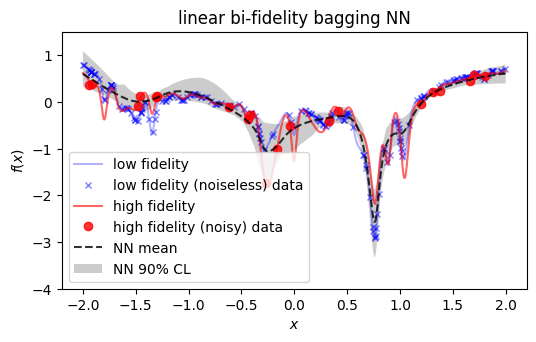

In [58]:
#@title
plt.figure(figsize=[6,3.4], dpi=100)

plt.plot(xgrid, yLgrid, 'b', label='low fidelity',alpha=0.3)
plt.plot(xL,yL,'bx',label='low fidelity (noiseless) data',alpha=0.5,markersize=5)

plt.plot(xgrid, yHgrid, 'r', label='high fidelity',alpha=0.6)
plt.plot(xH[::2],yH[::2],'ro',label='high fidelity (noisy) data',alpha=0.8, markersize=6)

plt.plot(xgrid, bagH_mean, '--', color='k', alpha=0.8, label='NN mean')
plt.fill_between(xgrid, bagH_10, bagH_90, facecolor='k', alpha=0.2, label='NN 90% CL')

plt.title('linear bi-fidelity bagging NN')
plt.xlabel('$x$'); plt.ylabel('$f(x)$')
plt.ylim(-4,1.5)
plt.legend();
mlai.write_figure('linear-bi-fidelity-baggingNN.svg', directory='./')
plt.show()